In [1]:
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange

sys.path.append("..")
from loss import *
from preprocess import preprocess
from scheduler import CosineScheduler

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda:1")

In [2]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

In [3]:
xyt, field, nu = preprocess(data)

# Subsample time, trajectory
time = xyt[:, :, :, -1]
t_step = time.unique()

r_t = 10
t_step_sub = t_step[::r_t]
# t_iter = len(t_step_sub)-1

field = field[::r_t, :, :, :] # field subsampling
field.shape

torch.Size([201, 101, 101, 2])

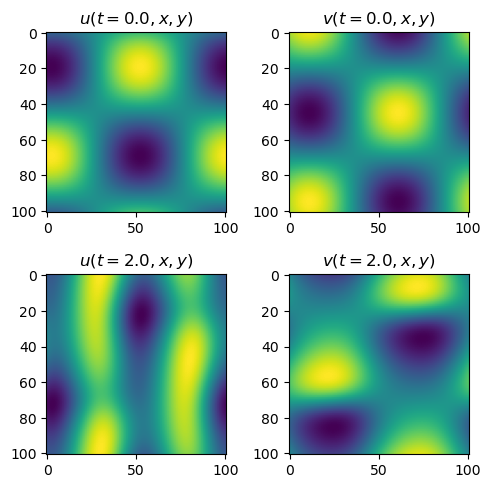

In [4]:
t_init_index = 0
t_final_index = -1
t_init = t_step_sub[t_init_index]
t_final = t_step_sub[t_final_index]

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(2, 2, 1)
img1 = ax1.imshow(field[t_init_index, :, :, 0])
ax1.set_title(r"$u(t={:.1f},x,y)$".format(t_init))

ax2 = fig.add_subplot(2, 2, 2)
img2 = ax2.imshow(field[t_init_index, :, :, 1])
ax2.set_title(r"$v(t={:.1f},x,y)$".format(t_init))

ax3 = fig.add_subplot(2, 2, 3)
img3 = ax3.imshow(field[t_final_index, :, :, 0])
ax3.set_title(r"$u(t={:.1f},x,y)$".format(t_final))

ax4 = fig.add_subplot(2, 2, 4)
img4 = ax4.imshow(field[t_final_index, :, :, 1])
ax4.set_title(r"$v(t={:.1f},x,y)$".format(t_final))

fig.tight_layout()
fig.show()

In [5]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.parameter.Parameter(
            self.scale
            * torch.rand(
                in_channels,
                out_channels,
                self.modes1,
                self.modes2,
                dtype=torch.complex64,
            )
        )
        self.weights2 = nn.parameter.Parameter(
            self.scale
            * torch.rand(
                in_channels,
                out_channels,
                self.modes1,
                self.modes2,
                dtype=torch.complex64,
            )
        )

    def compl_mul2d(self, input: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        """
        Complex multiplication
        Args
        input: [batch, in_channel, x, y]
        weights: [in_channel, out_channel, x, y]

        Returns
        result: [batch, out_channel, x, y]
        """
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        num_batch = x.shape[0]

        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            num_batch,
            self.out_channels,
            x.shape[-2],
            x.shape[-1] // 2 + 1,
            dtype=torch.complex64,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.shape[-2], x.shape[-1]))
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, mid_channels: int):
        super().__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

In [7]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super().__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (u(t, x, y), v(t, x, y), x, y)
        input shape: (num_batch, x=s, y=s, c=4)
        output: the solution u(t+dt, x, y)
        output shape: (num_batch, x=s, y=s, c=2)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        #         self.padding = 9 # pad the domain if input is non-periodic

        # input channel is 3: (u(t, x, y), v(t, x, y), x, y)
        self.p = nn.Linear(4, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(
            self.width, 2, self.width * 4
        )  # output channel is 2: (u(t+dt, x, y), v(t+dt, x, y))

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        #         x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        #         x = x[..., :-self.padding, :-self.padding]
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape: torch.Size, device: torch.device):
        num_batch, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.linspace(0.0, 1.0, size_x, device=device)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([num_batch, 1, size_y, 1])

        gridy = torch.linspace(0.0, 1.0, size_y, device=device)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([num_batch, size_x, 1, 1])

        return torch.cat((gridx, gridy), dim=-1)

In [8]:
s = 101  # Grid size
modes = 16
width = 32
model = FNO2d(modes, modes, width).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = CosineScheduler(
    optimizer, lr_max=1e-3, period=100, lr_max_mult=0.5, period_mult=2.0
)
myloss = LpLoss(size_average=False)

print(f"The number of parameters: {count_trainable_param(model):,}")

The number of parameters: 2,114,466


In [9]:
x_train = field[:-1]
y_train = field[1:]
# x_test = field[:-1, :, :, :]
# y_test = field[1:, :, :, :]

x_train = x_train.reshape(-1, s, s, 2)
# x_test = x_test.reshape(ntest,s,s,2)


batch_size = 20
train_loader = DataLoader(
    TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [10]:
num_epochs = 700
train_losses: list[float] = []

best_loss = 9999.0
best_model_state_dict = copy.deepcopy(model.state_dict())
for epoch in trange(num_epochs):
    model.train()
    losses: list[torch.Tensor] = []
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = myloss(out, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step(epoch + i / len(train_loader))

        losses.append(loss.detach())

    train_loss = torch.as_tensor(losses).mean().item()
    train_losses.append(train_loss)
    if best_loss > train_loss:
        best_model_state_dict = copy.deepcopy(model.state_dict())
        best_loss = train_loss

    if epoch % 10 == 0:
        tqdm.write(f"[Epoch {epoch}], Train loss: {train_loss:.4f}")

last_model_state_dict = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_state_dict)


  0%|          | 0/700 [00:00<?, ?it/s]

[Epoch 0], Train loss: 15.5811
[Epoch 10], Train loss: 1.0386
[Epoch 20], Train loss: 0.2314
[Epoch 30], Train loss: 0.2202
[Epoch 40], Train loss: 0.1466
[Epoch 50], Train loss: 0.1053
[Epoch 60], Train loss: 0.0825
[Epoch 70], Train loss: 0.0652
[Epoch 80], Train loss: 0.0594
[Epoch 90], Train loss: 0.0544
[Epoch 100], Train loss: 0.0854
[Epoch 110], Train loss: 0.1047
[Epoch 120], Train loss: 0.0972
[Epoch 130], Train loss: 0.1156
[Epoch 140], Train loss: 0.1040
[Epoch 150], Train loss: 0.0802
[Epoch 160], Train loss: 0.0875
[Epoch 170], Train loss: 0.0775
[Epoch 180], Train loss: 0.0759
[Epoch 190], Train loss: 0.0855
[Epoch 200], Train loss: 0.0579
[Epoch 210], Train loss: 0.0501
[Epoch 220], Train loss: 0.0470
[Epoch 230], Train loss: 0.0472
[Epoch 240], Train loss: 0.0440
[Epoch 250], Train loss: 0.0434
[Epoch 260], Train loss: 0.0410
[Epoch 270], Train loss: 0.0397
[Epoch 280], Train loss: 0.0392
[Epoch 290], Train loss: 0.0388
[Epoch 300], Train loss: 0.0519
[Epoch 310], Train

<All keys matched successfully>

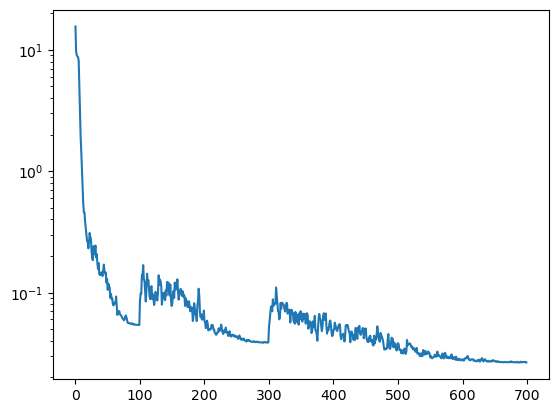

In [11]:
plt.plot(train_losses)
plt.yscale("log")

In [12]:
t_iter = 10
model.eval()

x_input = x_train[0].view(1, s, s, 2).to(device)
y_pred = model(x_input)

for _ in range(t_iter-1):
    x_input = y_pred
    y_pred = model(x_input)
y_pred = y_pred.cpu().detach().numpy()


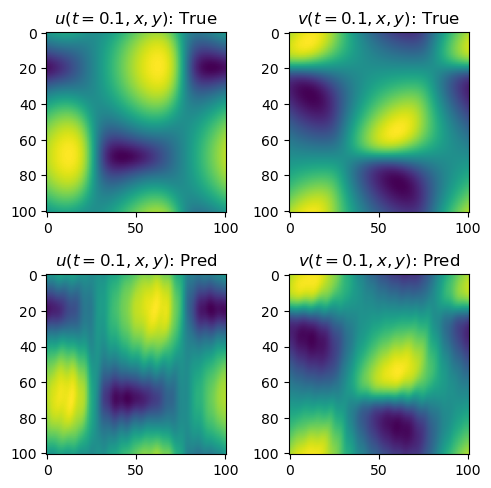

In [13]:
t_init_index = 0
t_final_index = t_iter
t_init = t_step_sub[t_init_index]
t_final = t_step_sub[t_final_index]

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(2,2,1)
img1 = ax1.imshow(y_train[t_final_index, :, :, 0])
ax1.set_title(r'$u(t={:.1f},x,y)$: True'.format(t_final))

ax2 = fig.add_subplot(2,2,2)
img2 = ax2.imshow(y_train[t_final_index, :, :, 1])
ax2.set_title(r'$v(t={:.1f},x,y)$: True'.format(t_final))

ax3 = fig.add_subplot(2,2,3)
img3 = ax3.imshow(y_pred[0, :, :, 0])
ax3.set_title(r'$u(t={:.1f},x,y)$: Pred'.format(t_final))

ax4 = fig.add_subplot(2,2,4)
img4 = ax4.imshow(y_pred[0, :, :, 1])
ax4.set_title(r'$v(t={:.1f},x,y)$: Pred'.format(t_final))

fig.tight_layout()
fig.show()

In [15]:
pred_trajectory = y_pred
true_trajectory = field[t_final_index, :, :, :].cpu().numpy()
true_trajectory = true_trajectory.reshape(1, s, s, 2)

error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=1.4062e-02, in range (-0.07280337, 0.07285048)


In [18]:
pred_trajectory = y_pred
true_trajectory = field[t_final_index, :, :, :].cpu().numpy()
true_trajectory = true_trajectory.reshape(1, s, s, 2)

error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=3.9205e-03, in range (-0.03195098, 0.0338206)
